# get signal

In [26]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests
from funcs import *
import pickle
import warnings

warnings.simplefilter("error")

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
tickerpairs=["ETCUSDT","GBPUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","AUDUSDT","XMRUSDT"] 

intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']



# define constants
tickerpair="ETCUSDT"
interval="5m"
percentile=98
thres_diff=None
#thres_diff = 0.003489
#thres_diff=0.004225 #ETCUSDT 30m 98%
#thres_diff=0.002227 #ETCUSDT 15m 98%
#thres_diff=0.0009295 *0.95 #ETCUSDT 5m 98%
entered=False

#percentiles = np.arange(55,100,20)
percentiles = [99]#[90,93,95,98,99]#[:1]
intervals=['5m','15m','30m']#[-1:]
tickerpairs=['ARBUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BTCUSDT',
             'ETCUSDT', 'ETHUSDT', 'LTCUSDT', 'MATICUSDT','SHIBUSDT', 
             'SOLUSDT','WAVESUSDT','XRPUSDT']
tickerpairs=os.listdir("kline_data/")
#tickerpairs=["ARBUSDT","ETCUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","XVGUSDT"]#[:1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%%time
dfmpl = get_data(tickerpair,"30m",limit=55000,type="data")
len(dfmpl)

CPU times: total: 219 ms
Wall time: 353 ms


55000

In [28]:
print("total",len(tickerpairs)*len(intervals)*len(percentiles))

total 2457


In [29]:
%%time
count=0;fee=0.0015
times=[]
print("total",len(tickerpairs)*len(intervals)*len(percentiles))
for tickerpair in tickerpairs:#[:5]:
    for interval in intervals:
        times.append( time.time() )
        try:
            dfmpl = get_data(tickerpair,interval,limit=55000,type="data")
        except ValueError:
            continue
        #if len(dfmpl)<20000:continue
        times.append( time.time() )
        for percentile in percentiles:
            if count%10==0:print(count,end=" ")#,tickerpair,interval,percentile)
            count+=1
            thres_diff=None
            entered=False
            times.append( time.time() )
            entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff = get_entrys_exits(dfmpl,percentile,thres_diff)
            times.append( time.time() )
            predict,result,predict_seq,predicted_result = get_predictions(entrys,exits,dfmpl)
            times.append( time.time() )
            lastNsamples = int(len(result)*0.1)
            profit,trade_dur, df0, df0_signal,hl_pair = get_profit_highlows_of_predictions(entrys,exits,predicted_result,dfmpl,True)
            times.append( time.time() )
            profit = [p-fee for p in profit]
            if len(profit)==0:
                print("\nzero profit",tickerpair,interval,percentile)
                continue
            final_profit,equity = get_all_equity(profit,fee=0)
            
            pickled_data=(entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff,
                          predict,result,predict_seq,predicted_result,
                          profit,trade_dur, df0, df0_signal,hl_pair,
                          final_profit,equity
                         )
            with open(f"5_9_3_data/plotdata_{tickerpair}_{interval}_{percentile}.pkl","wb") as f:
                pickle.dump(pickled_data,f)
            times.append( time.time() )

total 2457
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 
zero profit DGBBTC 5m 99
640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 

KeyboardInterrupt: 

# looped runs to plot

In [23]:
def plotresults(pickled_data2):
    (entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff,
    predict,result,predict_seq,predicted_result,profit,trade_dur,df0,
    df0_signal,hl_pair,final_profit,equity)=pickled_data2
    lastNsamples = int(len(result)*0.1)
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,5),sharex=True,dpi=100)
    ax1.plot(equity,"-x")
    ax1.set_ylabel("equity (start with $1)")
    ax1.set_title(f"{tickerpair} {interval} {percentile}% fee{fee} buy only")
    str1,gains_,trading_days,gains_per_day,gains_per_trade,avg_prof,wr= get_stats(dfmpl,sc_up,profit,trade_dur,0,fee=0)
    gs = get_stats(dfmpl,sc_up,profit,trade_dur,lastNsamples,fee=0)[0]
    ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
    ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+gs,transform=ax1.transAxes,va="top",ha="left")
    ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
    ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
    ax2.plot(profit,"x")
    ax2.axhline(0,c="r",alpha=0.3)
    ax2.set_ylabel("profit per trade")
    ax2.text(0.02,0.99,f"full len={len(dfmpl)}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left") 
    for ax in (ax1,ax2):
        ax.set_xlabel("trades")
        ax.tick_params("both",direction="in")
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.tick_params("y",which='minor',color="r")
    ax2.grid(which='minor',axis="y",alpha=0.5)
    ax2.grid(which='major',axis="y",color="r",alpha=0.5) 
    ax3 = ax2.inset_axes((1.05,0.1,0.3,0.3)) 
    ax3.text(0,1,"pfHist,g/trd",transform=ax3.transAxes,va="top",ha="left")
    ax3.hist(profit,bins=100)
    ax3.axvline(0,c="r",alpha=0.3)
    ax3.tick_params("both",direction="in",rotation=25,color="r") 
    ax3.set_yticks([])
    ax3.set_facecolor(f'#00{intpl(gains_per_trade*10,0,20):02X}0f60')
    ax4 = ax2.inset_axes((1.05,0.65,0.3,0.3))
    ax4.hist(r_sm_diff,bins=100)
    ax4.text(0,1,"thresDiff,g/day",transform=ax4.transAxes,va="top",ha="left") 
    ax4.axvline(thres_diff,c="r")
    ax4.tick_params("both",direction="in",rotation=25,color="r")
    ax4.set_yticks([])
    ax4.set_facecolor(f'#00{intpl(gains_per_day*10,0,20):02X}0f60')

    ax5 = ax1.inset_axes((1.05,0.0,0.4,0.99))
    hl_data = get_hl_data(hl_pair,buyonly=True) 
    plot_hl_ax(ax5,hl_pair,hl_data,bres=0.1,buyonly=True) 
    plt.tight_layout(h_pad=-1.08)
    plt.savefig(f"5_9_3_figures/FeeBO_{tickerpair}_{interval}_pcent{int(percentile):05d}.png")
    plt.close("all")

0 10 20 30 40 50 60 70 

KeyboardInterrupt: 

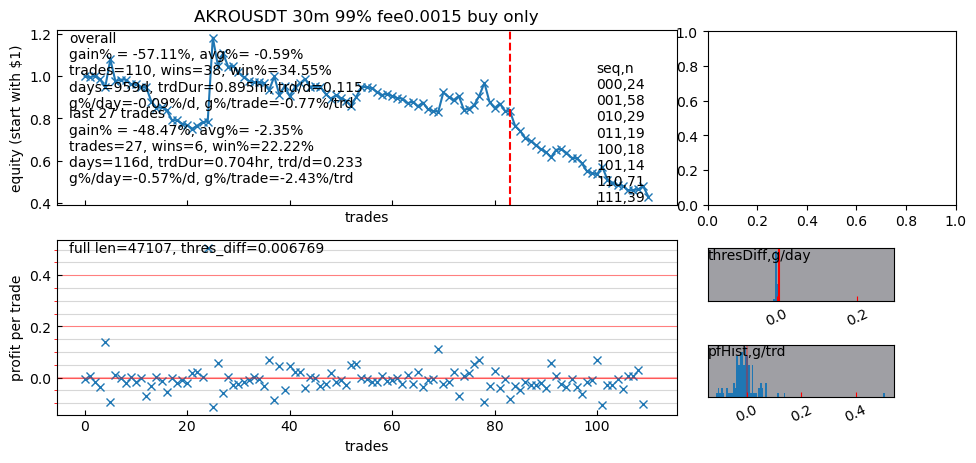

In [30]:
%%time
count=0
for tickerpair in tickerpairs:#[:5]:
    for interval in intervals:
        if count>1390:
            continue
        try:
            dfmpl = get_data(tickerpair,interval,limit=55000,type="data")
        except ValueError:
            continue
        for percentile in percentiles:
            if count%10==0:print(count,end=" ")#,tickerpair,interval,percentile)
            count+=1

            with open(f"5_9_3_data/plotdata_{tickerpair}_{interval}_{percentile}.pkl","rb") as f:
                pickled_data2 = pickle.load(f)
            (entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff,
            predict,result,predict_seq,predicted_result,profit,trade_dur,df0,
            df0_signal,hl_pair,final_profit,equity)=pickled_data2
            
            plotresults(pickled_data2)

In [18]:
(entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff,
 predict,result,predict_seq,predicted_result,profit,trade_dur,df0,
 df0_signal,hl_pair,final_profit,equity)=pickled_data2

# plotting pickled data

In [19]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,5),sharex=True,dpi=100)
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(f"{tickerpair} {interval} {percentile}% fee{fee} buy only")
str1,gains_,trading_days,gains_per_day,gains_per_trade,avg_prof,wr= get_stats(dfmpl,sc_up,profit,trade_dur,0,fee=0)
gs = get_stats(dfmpl,sc_up,profit,trade_dur,lastNsamples,fee=0)[0]
ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+gs,transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
ax2.plot(profit,"x")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")
ax2.text(0.02,0.99,f"full len={len(dfmpl)}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left") 
for ax in (ax1,ax2):
    ax.set_xlabel("trades")
    ax.tick_params("both",direction="in")
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params("y",which='minor',color="r")
ax2.grid(which='minor',axis="y",alpha=0.5)
ax2.grid(which='major',axis="y",color="r",alpha=0.5)
#lt.tight_layout(h_pad=-1.08)

ax3 = ax2.inset_axes((1.05,0.1,0.3,0.3)) 
ax3.text(0,1,"pfHist,g/trd",transform=ax3.transAxes,va="top",ha="left")
ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("both",direction="in",rotation=25,color="r") 
ax3.set_yticks([])
ax3.set_facecolor(f'#00{intpl(gains_per_trade*10,0,20):02X}0f60')
ax4 = ax2.inset_axes((1.05,0.65,0.3,0.3))
ax4.hist(r_sm_diff,bins=100)
ax4.text(0,1,"thresDiff,g/day",transform=ax4.transAxes,va="top",ha="left") 
ax4.axvline(thres_diff,c="r")
ax4.tick_params("both",direction="in",rotation=25,color="r")
ax4.set_yticks([])
ax4.set_facecolor(f'#00{intpl(gains_per_day*10,0,20):02X}0f60')

ax5 = ax1.inset_axes((1.05,0.0,0.4,0.99))
hl_data = get_hl_data(hl_pair,buyonly=True) 
plot_hl_ax(ax5,hl_pair,hl_data,bres=0.1,buyonly=True) 
plt.tight_layout(h_pad=-1.08)
plt.savefig(f"5_9_3_figures/FeeBO_{tickerpair}_{interval}_pcent{int(percentile):05d}.png")
# tp=(hl_data[0][0]+hl_data[0][1]*0.5)/100;
# sl=(hl_data[0][2]-hl_data[0][3]*3)/100
# strr =f'"tickerpair":"{tickerpair}","interval":"{interval}",'
# strr+=f'"sl":{sl:.4f},"tp":{tp:.4f},"percentile":{percentile},"thres_diff":{thres_diff:.7f}'
# with open(f"5_9_1_figures/collected_data5_9.data","a") as f:
#     f.writelines(strr+"\n")
# strr =f'{tickerpair},{interval},'
# strr+="TPSL "+",".join([f"{h:.4f}" for h in [tp,sl]])
# strr+=f"PTILE{percentile}thres_d{thres_diff:.7f}"+f",wr{wr:.2f},"
# strr+="HLPSTDMEAN,"+",".join([f"{h:.4f}" for h in hl_data[0]])
# with open(f"5_9_1_figures/collected_data5_9_others.data","a") as f:
#     f.writelines(strr+"\n")
plt.close("all")

# todo: extract the relevant columns

In [18]:
#(np.asarray(times).reshape(15,-1)-np.asarray(times).reshape(15,-1)[:,0][:,np.newaxis]).T
np.diff(np.asarray(times).reshape(15,-1),axis=1).shape

(15, 6)

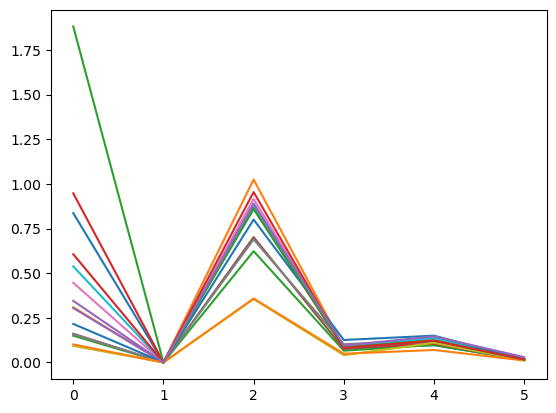

In [30]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

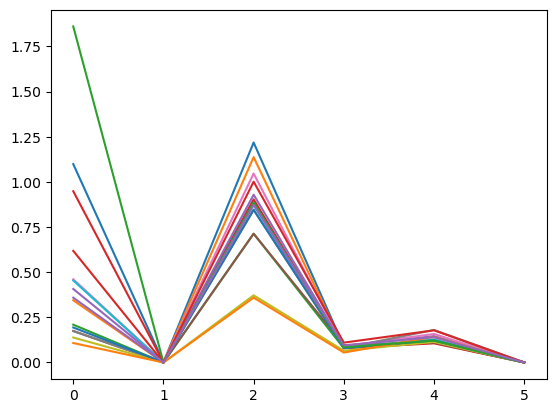

In [22]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

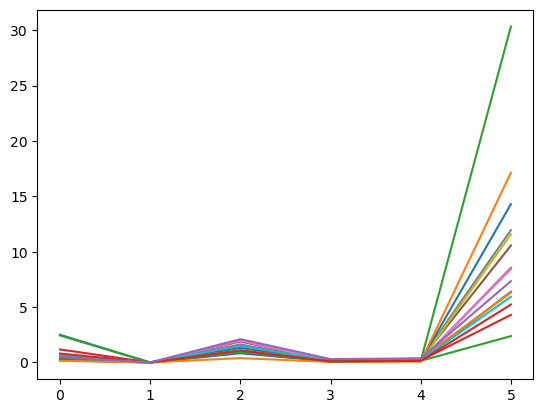

In [20]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

## sort by avg profit

In [5]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9_others.data","r") as f:
    data =f.readlines()

In [6]:
arr = [d[:-1].split(",") for d in data]

In [7]:
#[arr[i] for i in np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])][:15]

In [9]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9.data","r") as f:
    data =f.readlines()

In [11]:
#strr = "".join([data[i] for i in np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])])
strr=""
for counter,i in enumerate(np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])):
    strr+='{"id'+f'":{counter},'+data[i][:-1]+"},\n"

In [12]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9_others_sorted.data","w") as f:
    f.writelines(strr)

In [14]:
import random

1.4604162622819006

In [13]:
time.sleep(random.uniform(0.5,2))

In [ ]:
if False:
    continue
            fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,5),sharex=True,dpi=100)
            ax1.plot(equity,"-x")
            ax1.set_ylabel("equity (start with $1)")
            ax1.set_title(f"{tickerpair} {interval} {percentile}% fee{fee} buy only")
            str1,gains_,trading_days,gains_per_day,gains_per_trade,avg_prof,wr= get_stats(dfmpl,sc_up,profit,trade_dur,0,fee=0)
            gs = get_stats(dfmpl,sc_up,profit,trade_dur,lastNsamples,fee=0)[0]
            ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
            ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+gs,transform=ax1.transAxes,va="top",ha="left")
            ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
            ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
            ax2.plot(profit,"x")
            ax2.axhline(0,c="r",alpha=0.3)
            ax2.set_ylabel("profit per trade")
            ax2.text(0.02,0.99,f"full len={len(dfmpl)}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
            #ax2.text(0.02,0.99,f"thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
            for ax in (ax1,ax2):
                ax.set_xlabel("trades")
                ax.tick_params("both",direction="in")
            ax2.yaxis.set_minor_locator(AutoMinorLocator())
            ax2.tick_params("y",which='minor',color="r")
            ax2.grid(which='minor',axis="y",alpha=0.5)
            ax2.grid(which='major',axis="y",color="r",alpha=0.5)
            #lt.tight_layout(h_pad=-1.08)

            ax3 = ax2.inset_axes((1.05,0.1,0.3,0.3)) 
            ax3.text(0,1,"pfHist,g/trd",transform=ax3.transAxes,va="top",ha="left")
            ax3.hist(profit,bins=100)
            ax3.axvline(0,c="r",alpha=0.3)
            ax3.tick_params("both",direction="in",rotation=25,color="r") 
            ax3.set_yticks([])
            ax3.set_facecolor(f'#00{intpl(gains_per_trade*10,0,20):02X}0f60')
            ax4 = ax2.inset_axes((1.05,0.65,0.3,0.3))
            ax4.hist(r_sm_diff,bins=100)
            ax4.text(0,1,"thresDiff,g/day",transform=ax4.transAxes,va="top",ha="left") 
            ax4.axvline(thres_diff,c="r")
            ax4.tick_params("both",direction="in",rotation=25,color="r")
            ax4.set_yticks([])
            ax4.set_facecolor(f'#00{intpl(gains_per_day*10,0,20):02X}0f60')

            ax5 = ax1.inset_axes((1.05,0.0,0.4,0.99))
            hl_data = get_hl_data(hl_pair,buyonly=True) 
            plot_hl_ax(ax5,hl_pair,hl_data,bres=0.1,buyonly=True) 
            plt.tight_layout(h_pad=-1.08)
            #plt.savefig(f"5_8figures_percentile_ticker/{tickerpair}_{interval}_pcent{int(percentile):05d}.png") 
            plt.savefig(f"5_9_1_figures_temp/FeeBO_{tickerpair}_{interval}_pcent{int(percentile):05d}.png")
            plt.close("all")

In [5]:
%%time
if False:
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
    ax1.plot(r_high_sm,alpha=0.6)
    ax1.plot(r_low_sm,alpha=0.6)
    ax1.plot(r_sm,alpha=0.6)
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    n,bins,_ = ax2.hist(r_sm,bins=100)
    thres = np.percentile(r_sm.values[np.where(~np.isnan(r_sm.values))],25)
    ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
    ax2.legend()
    ax3.hist(r_sm_diff,bins=100)
    ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
    ax3.legend()
    plt.show()  
if False:
    upto=20
    concated_df = pd.concat([(i-i.iloc[0].Open)/i.iloc[0].Open for i in df0[:upto]])
    l_ = 0
    scatter_=[]
    scatter_color_up=[]
    scatter_color_dn=[]
    my_vlines = [ ]
    for i,buy in zip( df0[:upto], df0_signal):
        my_vlines.append(l_)
        for ii in range(len(i)):
            l_ +=1
            scatter_.append(np.nan)
            scatter_color_up.append(np.nan)
            scatter_color_dn.append(np.nan)
        scatter_.pop()
        scatter_.append(concated_df.iloc[l_-1].Close)
        if buy>0:
            scatter_color_up.pop()
            scatter_color_up.append(concated_df.iloc[l_-1].Close)
        else:
            scatter_color_dn.pop()
            scatter_color_dn.append(concated_df.iloc[l_-1].Close)
    apds = [
        mpf.make_addplot(scatter_color_up,color='g',type='scatter',marker="x",secondary_y=False),
        mpf.make_addplot(scatter_color_dn,color='r',type='scatter',marker="x",secondary_y=False),
           ]
    fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True,ylabel="fraction change")
    for ax in axlist[:]:
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
    plt.show()
    import matplotlib
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

CPU times: total: 0 ns
Wall time: 0 ns
